#Libraries and data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#change directory
%cd /content/drive/MyDrive/Time Series Forecasting Product

/content/drive/MyDrive/Time Series Forecasting Product


In [ ]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from sklearn.model_selection import ParameterGrid

In [ ]:
#load the data
#YYYY-MM-DD
df = pd.read_csv('nyc_data.csv')
df.head()

,Date,Demand,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,1/1/2015,720.000885,0,0,0,3.68,41.305
1,1/2/2015,581.276773,0,0,0,4.73,131.574
2,1/3/2015,754.117039,0,0,0,7.23,162.700
3,1/4/2015,622.252774,0,0,0,10.96,160.281
4,1/5/2015,785.373319,0,0,0,6.92,51.077


In [ ]:
#Rename variable
df = df.rename(columns = {'Demand': 'y',
                          'Date': 'ds'})
df.head(0)

,ds,y,Easter,Thanksgiving,Christmas,Temperature,Marketing


In [ ]:
#Date variable
df.ds = pd.to_datetime(df.ds,
                       format = "%m/%d/%Y")
df.ds

0      2015-01-01
1      2015-01-02
2      2015-01-03
3      2015-01-04
4      2015-01-05
          ...    
2187   2020-12-27
2188   2020-12-28
2189   2020-12-29
2190   2020-12-30
2191   2020-12-31
Name: ds, Length: 2192, dtype: datetime64[ns]

#Holidays

In [ ]:
#Easter
dates = pd.to_datetime(df[df.Easter == 1].ds)
easter = pd.DataFrame({'holiday': 'easter',
                       'ds': dates,
                       'lower_window': -5,
                       'upper_window': 2})

In [ ]:
#Thanksgiving
dates = pd.to_datetime(df[df.Thanksgiving == 1].ds)
thanksgiving = pd.DataFrame({'holiday': 'thanksgiving',
                             'ds': dates,
                             'lower_window': -3,
                             'upper_window': 6})
thanksgiving

,holiday,ds,lower_window,upper_window
329,thanksgiving,2015-11-26,-3,6
693,thanksgiving,2016-11-24,-3,6
1057,thanksgiving,2017-11-23,-3,6
1421,thanksgiving,2018-11-22,-3,6
1792,thanksgiving,2019-11-28,-3,6
2156,thanksgiving,2020-11-26,-3,6


In [ ]:
#Combining events
holidays = pd.concat([easter, thanksgiving])
holidays

,holiday,ds,lower_window,upper_window
94,easter,2015-04-05,-5,2
451,easter,2016-03-27,-5,2
836,easter,2017-04-16,-5,2
1186,easter,2018-04-01,-5,2
1571,easter,2019-04-21,-5,2
1928,easter,2020-04-12,-5,2
329,thanksgiving,2015-11-26,-3,6
693,thanksgiving,2016-11-24,-3,6
1057,thanksgiving,2017-11-23,-3,6
1421,thanksgiving,2018-11-22,-3,6


In [ ]:
df = df.drop(columns = ["Easter", "Thanksgiving"])
df.head(0)

,ds,y,Christmas,Temperature,Marketing


#Facebook Prophet model

In [ ]:
#FB model
m = Prophet(holidays = holidays,
            seasonality_mode = 'multiplicative',
            seasonality_prior_scale = 10,
            holidays_prior_scale = 10,
            changepoint_prior_scale = 0.05)
m.add_regressor('Christmas')
m.add_regressor('Temperature')
m.add_regressor('Marketing')
m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
#Check how many observations
df.shape[0] - 180

2012

In [ ]:
#Cross-validation
df_cv = cross_validation(m,
                         horizon = '31 days',
                         period = '16 days',
                         initial = '2012 days',
                         parallel = 'processes')
df_cv.head()  

INFO:fbprophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f607eb3aa10>


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-07-10,609.206496,543.913004,679.767372,571.069531,2020-07-09
1,2020-07-11,724.322721,661.184447,791.505926,677.106981,2020-07-09
2,2020-07-12,639.067101,573.731425,707.129067,619.572774,2020-07-09
3,2020-07-13,771.708402,702.638302,838.066166,808.932621,2020-07-09
4,2020-07-14,638.775451,578.022198,705.042069,661.791644,2020-07-09


In [ ]:
#PErformance
performance_metrics(df_cv).head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,4 days,2839.605270,53.287947,43.426834,0.059041,0.059995,0.767742
1,5 days,2836.518432,53.258975,44.627642,0.062439,0.063030,0.767742
2,6 days,3552.397768,59.601995,50.647597,0.070030,0.063030,0.703226
3,7 days,2824.397813,53.145064,42.947937,0.060575,0.058923,0.732258
4,8 days,2757.441095,52.511343,40.276313,0.055647,0.058688,0.735484


In [ ]:
#RMSE and MAPE
print("RMSE: ", round(performance_metrics(df_cv)["rmse"].mean(),1))
print("MAPE: ", 100 * round(performance_metrics(df_cv)["mape"].mean(),3), "%")

RMSE:  53.7
MAPE:  5.800000000000001 %


/usr/local/lib/python3.7/dist-packages/fbprophet/plot.py:526: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.7/dist-packages/fbprophet/plot.py:527: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


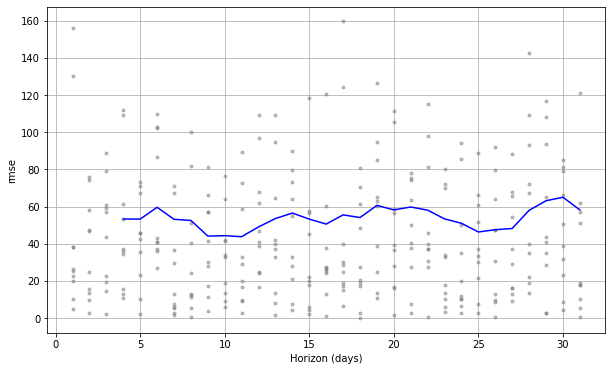

In [ ]:
#plotting
plot_cross_validation_metric(df_cv, metric = 'rmse');

#Parameter Tuning

In [ ]:
#Parameter Grid
param_grid = {'seasonality_mode': ["additive", 'multiplicative'],
              'seasonality_prior_scale': [1, 5, 10, 20],
              'holidays_prior_scale': [5, 10, 20, 25],
              'changepoint_prior_scale': [0.005, 0.01, 0.05, 0.1]}
grid = ParameterGrid(param_grid)
len(list(grid))

128

In [ ]:
#Store the results
rmse = []

#Loop
i = 1
for params in grid:
  print(f"{i} / {len(list(grid))}")
  #model
  m = Prophet(holidays = holidays,
              seasonality_mode = params['seasonality_mode'],
              seasonality_prior_scale = params['seasonality_prior_scale'],
              holidays_prior_scale = params['holidays_prior_scale'],
              changepoint_prior_scale = params['changepoint_prior_scale'])
  m.add_regressor('Christmas')
  m.add_regressor('Temperature')
  m.add_regressor('Marketing')
  m.fit(df)

  #CV
  df_cv = cross_validation(m,
                          horizon = '31 days',
                          period = '16 days',
                          initial = '2012 days',
                          parallel = 'processes')

  #Measure the error and store the result
  error = performance_metrics(df_cv)["rmse"].mean()
  rmse.append(error)

  i += 1

In [ ]:
#Check the results
tuning_results = pd.DataFrame(grid)
tuning_results['rmse'] = rmse
tuning_results

,changepoint_prior_scale,holidays_prior_scale,seasonality_mode,seasonality_prior_scale,rmse
0,0.005,5,additive,1,51.940950
1,0.005,5,additive,5,52.932272
2,0.005,5,additive,10,52.576736
3,0.005,5,additive,20,52.880008
4,0.005,5,multiplicative,1,50.386994
...,...,...,...,...,...
123,0.100,25,additive,20,49.429226
124,0.100,25,multiplicative,1,53.310911
125,0.100,25,multiplicative,5,53.354412
126,0.100,25,multiplicative,10,53.378774


In [ ]:
#export best parameters
best_params = tuning_results[tuning_results.rmse == tuning_results.rmse.min()].transpose()
best_params.to_csv("Forecasting Product/best_params_prophet.csv")